In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import mysql.connector

In [2]:
## Establishing connection with MySQL Database

db = mysql.connector.connect(host='localhost',
                             username = 'root',
                             password='root',
                             database='monday_coffee')

cur = db.cursor()

### Report and Analysis

**Coffee Consumers Count**

How many people in each city are estimated to consume coffee, given that 25% of the population does?

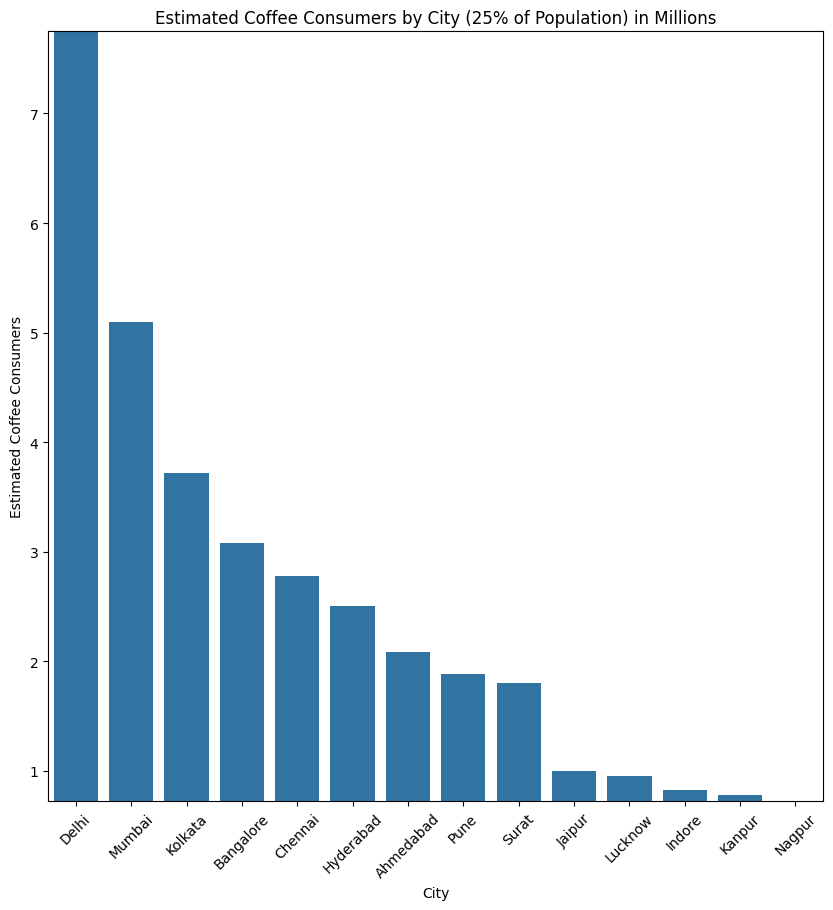

In [3]:
q1 = 'SELECT city_name, ROUND((0.25*population)/1000000,2) AS coffee_consumer FROM city ORDER BY 2 DESC'

## Executing and fetching sql data
cur.execute(q1)
d1 = cur.fetchall()

## Creating dataframe
df1 = pd.DataFrame(d1,columns=['city','coffee_consumer'])

plt.figure(figsize=(10,10))

## Bar chart parameters
sns.barplot(df1,x=df1['city'],y=df1['coffee_consumer'])

## Adding labels
plt.xlabel('City')
plt.ylabel('Estimated Coffee Consumers')
plt.title('Estimated Coffee Consumers by City (25% of Population) in Millions')

plt.xticks(rotation=45)
plt.ylim(df1['coffee_consumer'].min(), df1['coffee_consumer'].max())
plt.show()

 **Total Revenue from Coffee Sales**

What is the total revenue generated from coffee sales across all cities in the last quarter of 2023?


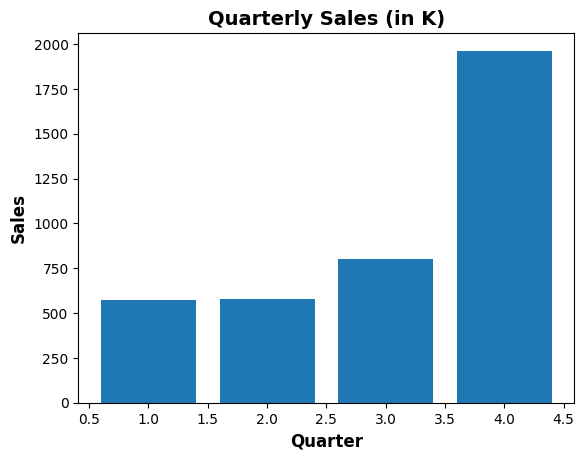

In [14]:
q2 = 'SELECT QUARTER(sale_date) AS quarter, SUM(total) AS total_revenue FROM sales WHERE YEAR(sale_date) = 2023 GROUP BY QUARTER(sale_date) ORDER BY 1'
cur.execute(q2)

d2 = cur.fetchall()
df2 = pd.DataFrame(d2,columns=['quarter','sales'])

df2['sales_k'] = df2['sales']//1000

plt.bar(df2['quarter'],df2['sales_k'])

plt.xlabel("Quarter", fontsize=12, fontweight="bold")
plt.ylabel("Sales", fontsize=12, fontweight="bold")
plt.title("Quarterly Sales (in K)", fontsize=14, fontweight="bold")

# Display the chart
plt.show()

**Sales Count for Each Product**

How many units of each coffee product have been sold?

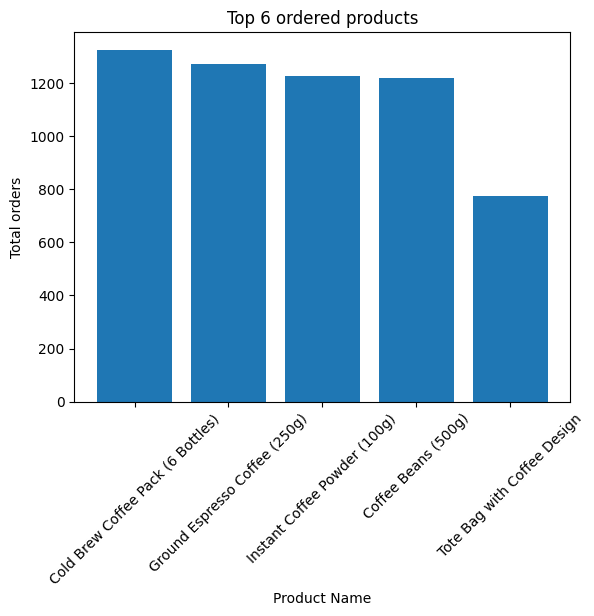

In [22]:
q3 = '''SELECT p.product_name,COUNT(s.sale_id) AS total_order
FROM products p
LEFT JOIN sales s ON s.product_id = p.product_id
GROUP BY 1
ORDER BY 2 DESC;'''

cur.execute(q3)
d3 = cur.fetchall()

df3 = pd.DataFrame(d3,columns=['name','total_orders'])

plt.bar(df3.head()['name'],df3.head()['total_orders'])
plt.xticks(rotation=45)
plt.xlabel("Product Name")
plt.ylabel("Total orders")
plt.title("Top 6 ordered products")
plt.show()

**Average Sales Amount per City**

1. What is the average sales amount per customer in each city?
2. city abd total sale
3. no cx in each these city

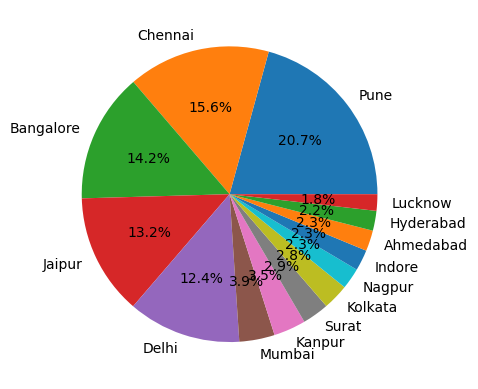

In [25]:
q4 = '''SELECT c.city_name, SUM(s.total) as total_sales,
COUNT(DISTINCT s.customer_id) as total_cx,
ROUND((SUM(s.total)/COUNT(DISTINCT s.customer_id)),2) as avg_sale_cx
FROM city c
JOIN customers cc ON cc.city_id = c.city_id
JOIN sales s ON s.customer_id = cc.customer_id
GROUP BY 1
ORDER BY 2 DESC;'''

cur.execute(q4)

d4 = cur.fetchall()
df4 = pd.DataFrame(d4,columns=['city','total_sales','customers','avg_cx_sale'])

plt.pie(df4['total_sales'],labels=df4['city'],autopct='%1.1f%%')
plt.show()

**City Population and Coffee Consumers (25%)**

-- Provide a list of cities along with their populations and estimated coffee consumers.

return city_name, total current cx, estimated coffee consumers (25%)

In [28]:
q5 = '''WITH city_table as 
(
	SELECT 
		city_name,
		ROUND((population * 0.25)/1000000, 2) as coffee_consumers
	FROM city
),
customers_table
AS
(
	SELECT 
		ci.city_name,
		COUNT(DISTINCT c.customer_id) as unique_cx
	FROM sales as s
	JOIN customers as c
	ON c.customer_id = s.customer_id
	JOIN city as ci
	ON ci.city_id = c.city_id
	GROUP BY 1
)
SELECT 
	customers_table.city_name,
	city_table.coffee_consumers as coffee_consumer_in_millions,
	customers_table.unique_cx
FROM city_table
JOIN 
customers_table
ON city_table.city_name = customers_table.city_name'''

cur.execute(q5)
d5 = cur.fetchall()
df5 = pd.DataFrame(d5,columns=['city_name','estimated_coffee_consumer_in_millions','unique_cx'])

df5.head()

,city_name,estimated_coffee_consumer_in_millions,unique_cx
0,Ahmedabad,2.08,23
1,Bangalore,3.08,39
2,Chennai,2.78,42
3,Delhi,7.75,68
4,Hyderabad,2.50,21


**Top Selling Products by City**

What are the top 3 selling products in each city based on sales volume?

In [30]:
q6 = '''SELECT * FROM(
SELECT ci.city_name,p.product_name,SUM(s.total) AS total_sales,
DENSE_RANK() OVER(PARTITION BY ci.city_name ORDER BY SUM(s.total) DESC) AS dnk
FROM sales s
JOIN products p ON p.product_id = s.product_id
JOIN customers c ON c.customer_id = s.customer_id
JOIN city ci ON ci.city_id = c.city_id
GROUP BY 1,2
ORDER BY 1) AS t1
WHERE dnk<=3;'''

cur.execute(q6)
d6 = cur.fetchall()
df6 = pd.DataFrame(d6,columns=['city','product','total_sales','rank'])
df6.head(10)

,city,product,total_sales,rank
0,Ahmedabad,Cold Brew Coffee Pack (6 Bottles),36000.0,1
1,Ahmedabad,Coffee Beans (500g),21000.0,2
2,Ahmedabad,Coffee Gift Hamper,14400.0,3
3,Bangalore,Cold Brew Coffee Pack (6 Bottles),177300.0,1
4,Bangalore,Coffee Beans (500g),84000.0,2
5,Bangalore,Coffee Gift Hamper,68400.0,3
6,Chennai,Cold Brew Coffee Pack (6 Bottles),172800.0,1
7,Chennai,Coffee Beans (500g),108600.0,2
8,Chennai,Tote Bag with Coffee Design,69500.0,3
9,Delhi,Cold Brew Coffee Pack (6 Bottles),140400.0,1


**Customer Segmentation by City**

How many unique customers are there in each city who have purchased coffee products?

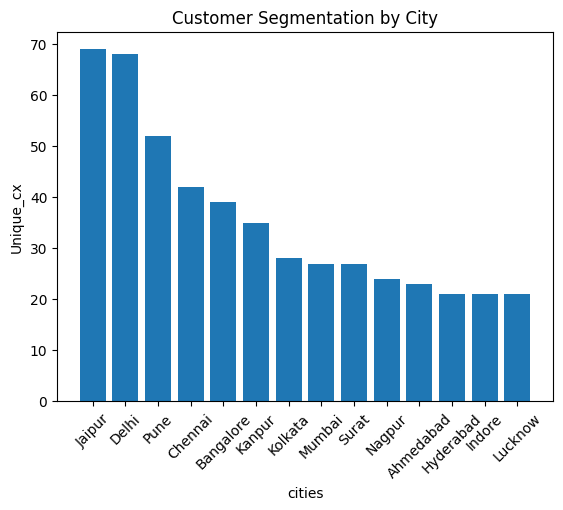

In [33]:
q7 = '''SELECT ci.city_name, COUNT(DISTINCT c.customer_id) as unique_cx
FROM sales s 
JOIN customers c ON c.customer_id = s.customer_id
JOIN city ci ON ci.city_id = c.city_id
GROUP BY 1
ORDER BY 2 DESC;'''

cur.execute(q7)
d7 = cur.fetchall()

df7 = pd.DataFrame(d7,columns=['city','unique_cx'])
plt.bar(df7['city'],df7['unique_cx'])
plt.xticks(rotation = 45)
plt.xlabel("cities")
plt.ylabel('Unique_cx')
plt.title("Customer Segmentation by City")
plt.show()

**Average Sale vs Rent**

Find each city and their average sale per customer and avg rent per customer

C:\Users\tejas\AppData\Local\Temp\ipykernel_28692\3228420905.py:42: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(df8['city'], rotation=30, ha='right')


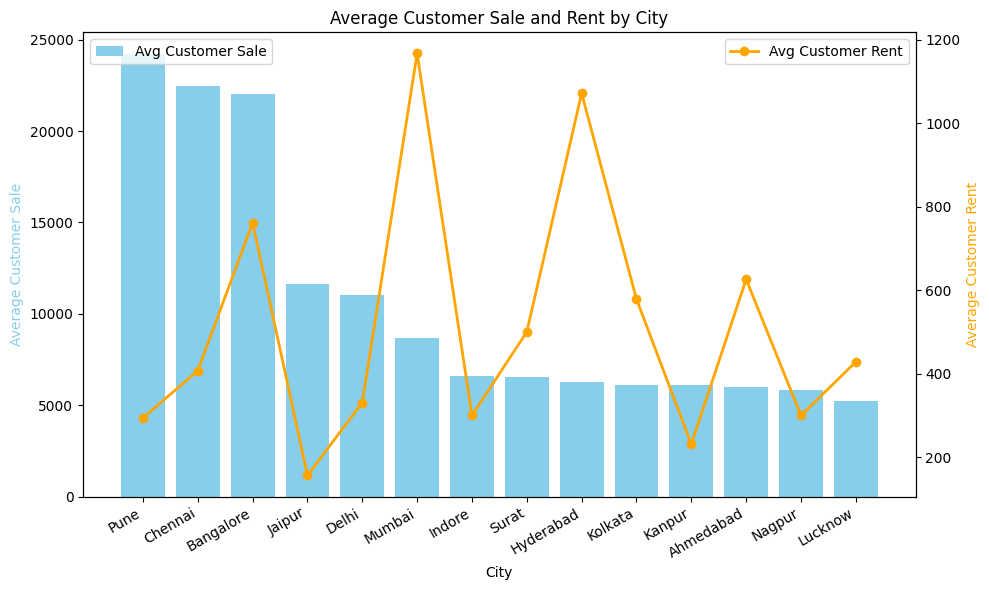

In [42]:
q8 = '''WITH city_sale AS(
SELECT ci.city_name,
COUNT(DISTINCT s.customer_id) AS unique_cx,
ROUND((SUM(s.total)/COUNT(DISTINCT s.customer_id)),2) AS avg_sale_pr_cx
FROM sales s
JOIN customers c ON c.customer_id = s.customer_id
JOIN city ci ON ci.city_id = c.city_id
GROUP BY ci.city_name
)

SELECT c.city_name,c.estimated_rent,cs.unique_cx,cs.avg_sale_pr_cx,
ROUND(c.estimated_rent/cs.unique_cx,2) AS avg_rent_per_cx
FROM city c
JOIN city_sale cs ON cs.city_name = c.city_name
ORDER BY 4 DESC;'''

cur.execute(q8)
d8 = cur.fetchall()

df8 = pd.DataFrame(d8,columns=['city','estimated rent','unique_cx','avg_sale_pr_cx','avg_rent_pr_cx'])
df8.head(15)

# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Plot avg_customer_sale as a bar chart
ax.bar(df8['city'], df8['avg_sale_pr_cx'], color='skyblue', label='Avg Customer Sale')

# Plot avg_customer_rent as a line chart
ax2 = ax.twinx()  # Create a secondary y-axis
ax2.plot(df8['city'], df8['avg_rent_pr_cx'], marker='o', color='orange', label='Avg Customer Rent', linewidth=2)

# Add labels and title
ax.set_xlabel('City')
ax.set_ylabel('Average Customer Sale', color='skyblue')
ax2.set_ylabel('Average Customer Rent', color='orange')
ax.set_title('Average Customer Sale and Rent by City')

# Add legends
ax.legend(loc='upper left')
ax2.legend(loc='upper right')
ax.set_xticklabels(df8['city'], rotation=30, ha='right')

# Display the plot
plt.tight_layout()
plt.show()

**Monthly Sales Growth**


Sales growth rate: Calculate the percentage growth (or decline) in sales over different time periods (monthly) by each city

C:\Users\tejas\AppData\Local\Temp\ipykernel_28692\291436406.py:63: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(df9['time'].unique(), rotation=45, ha='right')


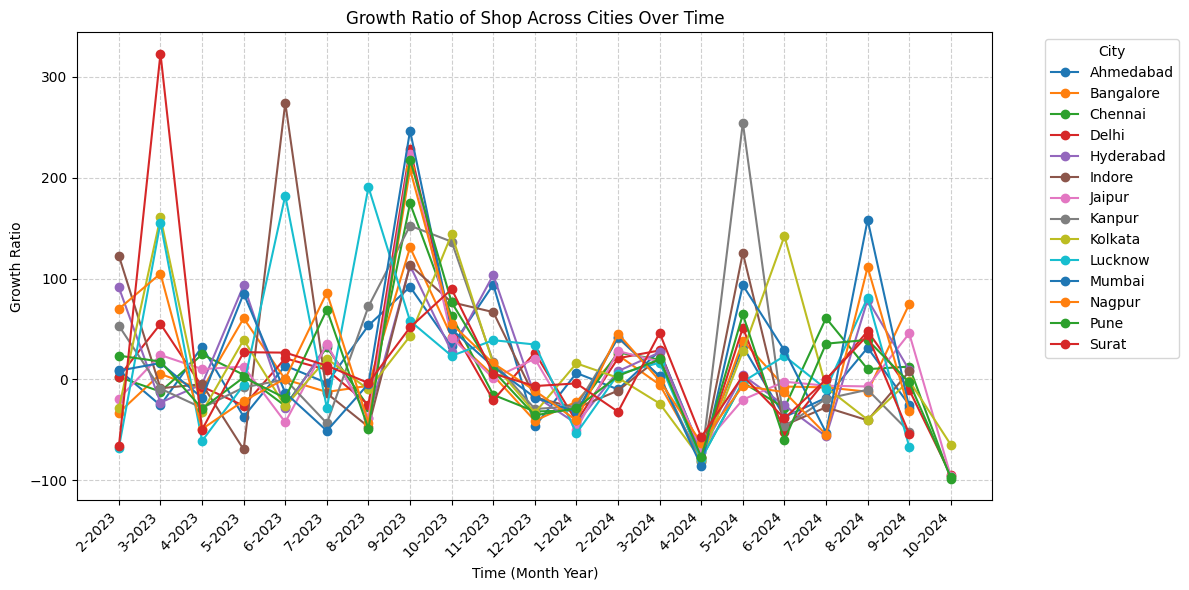

In [46]:
q9 = '''WITH monthly_sales AS
(
	SELECT 
		ci.city_name,
		EXTRACT(MONTH FROM sale_date) as month,
		EXTRACT(YEAR FROM sale_date) as YEAR,
		SUM(s.total) as total_sale
	FROM sales as s
	JOIN customers as c
	ON c.customer_id = s.customer_id
	JOIN city as ci
	ON ci.city_id = c.city_id
	GROUP BY 1, 2, 3
	ORDER BY 1, 3, 2
),

growth_ratio AS
(
		SELECT
			city_name,
			month,
			year,
			total_sale as cr_month_sale,
			LAG(total_sale, 1) OVER(PARTITION BY city_name ORDER BY year, month) as last_month_sale
		FROM monthly_sales
)

SELECT
	city_name,
	month,
	year,
	cr_month_sale,
	last_month_sale,
	ROUND(
		(cr_month_sale-last_month_sale)/last_month_sale* 100, 2
		) as growth_ratio

FROM growth_ratio
WHERE 
	last_month_sale IS NOT NULL;'''

cur.execute(q9)
d9 = cur.fetchall()

df9 = pd.DataFrame(d9,columns=['city','month','year','current_month_sales','last_month_sales','growth_ratio'])
# Combine 'year' and 'month' into a single 'time' column for plotting
df9['time'] = df9['month'].astype(str) + '-' + df9['year'].astype(str)

# Create a figure and axis
fig, ax = plt.subplots(figsize=(12, 6))

# Plot growth ratio for each city
for city in df9['city'].unique():
    city_data = df9[df9['city'] == city]
    ax.plot(city_data['time'], city_data['growth_ratio'], marker='o', label=city)

# Add labels and title
ax.set_xlabel('Time (Month Year)')
ax.set_ylabel('Growth Ratio')
ax.set_title('Growth Ratio of Shop Across Cities Over Time')

# Rotate x-axis labels for better readability
ax.set_xticklabels(df9['time'].unique(), rotation=45, ha='right')

# Add a legend
ax.legend(title='City', bbox_to_anchor=(1.05, 1), loc='upper left')

# Add grid for better visualization
ax.grid(True, linestyle='--', alpha=0.6)

# Display the plot
plt.tight_layout()
plt.show()


**Market Potential Analysis**

Identify top 3 city based on highest sales, return city name, total sale, total rent, total customers, estimated coffee consumer


In [47]:
q10 = '''WITH city_table
AS
(
	SELECT 
		ci.city_name,
		SUM(s.total) as total_revenue,
		COUNT(DISTINCT s.customer_id) as total_cx,
		ROUND(
				SUM(s.total)/COUNT(DISTINCT s.customer_id),2) as avg_sale_pr_cx
	FROM sales as s
	JOIN customers as c
	ON s.customer_id = c.customer_id
	JOIN city as ci
	ON ci.city_id = c.city_id
	GROUP BY 1
	ORDER BY 2 DESC
),
city_rent
AS
(
	SELECT 
		city_name, 
		estimated_rent,
		ROUND((population * 0.25)/1000000, 3) as estimated_coffee_consumer_in_millions
	FROM city
)
SELECT 
	cr.city_name,
	total_revenue,
	cr.estimated_rent as total_rent,
	ct.total_cx,
	estimated_coffee_consumer_in_millions,
	ct.avg_sale_pr_cx,
	ROUND(
		cr.estimated_rent/ct.total_cx
		, 2) as avg_rent_per_cx
FROM city_rent as cr
JOIN city_table as ct
ON cr.city_name = ct.city_name
ORDER BY 2 DESC'''

cur.execute(q10)
d10 = cur.fetchall()

df10 = pd.DataFrame(d10,columns=['city','total_revenue','total_rent','total_cx','estimated_coffee_consumer_in_millions','avg_sale_pr_cx','avg_rent_per_cx'])
df10.head()

,city,total_revenue,total_rent,total_cx,estimated_coffee_consumer_in_millions,avg_sale_pr_cx,avg_rent_per_cx
0,Pune,1258290.0,15300,52,1.875,24197.88,294.23
1,Chennai,944120.0,17100,42,2.775,22479.05,407.14
2,Bangalore,860110.0,29700,39,3.075,22054.10,761.54
3,Jaipur,803450.0,10800,69,1.000,11644.20,156.52
4,Delhi,750420.0,22500,68,7.750,11035.59,330.88


# Conclusion

City 1: Pune
1. Average rent per customer is very low.
2. Highest total revenue.
3. Average sales per customer is also high.


City 2: Delhi
1. Highest estimated coffee consumers at 7.7 million.
2. Highest total number of customers, which is 68.
3. Average rent per customer is 330 (still under 500).
    

City 3: Jaipur
1. Highest number of customers, which is 69.
2. Average rent per customer is very low at 156.
3. Average sales per customer is better at 11.6k.